In [90]:
import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import resample
from gensim.models import Word2Vec
import gensim.downloader as api
import numpy as np
import gensim
import zipfile
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Input, LSTM, GRU, Dense, Embedding, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras import backend as K
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

keras-tuner for hyper parameter tunning 

In [74]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [2]:
# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
data = pd.read_csv('/content/labeled_data.csv')
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Q1:Write a Python function to remove stopwords, punctuation, special characters, and
unwanted symbols from a given text corpus from the Hate Speech and Offensive Language
dataset.(https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language
dataset)

In [4]:
# Preprocessing function
def preprocess_text(text):
    """
    Preprocesses the input text by:
    1. Removing punctuation and special characters.
    2. Converting text to lowercase.
    3. Removing stopwords.
    4. Removing extra spaces.

    Args:
        text (str): Input text to preprocess.

    Returns:
        str: Preprocessed text.
    """
    # Step 1: Remove punctuation and special characters using regex
    text = re.sub(r'[^\w\s]', '', text)  # Keep only alphanumeric and spaces

    # Step 2: Convert text to lowercase
    text = text.lower()

    # Step 3: Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])

    # Step 4: Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:
# Apply the preprocessing function to the 'tweet' column
data['cleaned_tweet'] = data['tweet'].apply(preprocess_text)

### Text Preprocessing Function in Python

This Python code defines a function called `preprocess_text`, which is designed to clean and standardize textual data. The function follows a structured approach to preprocess text: it removes punctuation and special characters using regular expressions, converts the text to lowercase to maintain uniformity, eliminates common stopwords (like "the," "is," and "and") to focus on meaningful words, and removes extra spaces to ensure a clean output. After defining this function, it is applied to a dataset column named `'tweet'`, creating a new column, `'cleaned_tweet'`, containing the processed text. This preprocessing step is crucial because it helps in reducing noise and improving model performance by focusing only on relevant words. Finally, the dataset is displayed to show the original and cleaned tweets for comparison.

In [6]:
# Display the updated dataset
data[['tweet', 'cleaned_tweet']].head()

,tweet,cleaned_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely woman shouldnt complain cleani...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt c_g_anderson viva_based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts shit hear might true might f...


In [7]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,cleaned_tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,rt mayasolovely woman shouldnt complain cleani...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt c_g_anderson viva_based look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shenikaroberts shit hear might true might f...


Q2: Implement a tokenizer that converts sentences from the Hate Speech dataset into sequences
suitable for embedding layers.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  # Set a vocabulary size and out-of-vocabulary token

# Fit the tokenizer on the cleaned tweets
tokenizer.fit_on_texts(data['cleaned_tweet'])

# Convert text into sequences
sequences = tokenizer.texts_to_sequences(data['cleaned_tweet'])

# Pad sequences to ensure uniform input size
max_length = max(len(seq) for seq in sequences)  # Find the longest sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

### Tokenization and Padding for Text Processing

This code snippet utilizes TensorFlow's `Tokenizer` and `pad_sequences` functions to prepare textual data for deep learning models. The first step involves defining a `Tokenizer` with a vocabulary size of 10,000 words and an out-of-vocabulary token (`<OOV>`) to handle unseen words. The tokenizer is then trained on the preprocessed text (`'cleaned_tweet'`), converting words into unique integer sequences. After tokenization, the text is transformed into numerical sequences using `texts_to_sequences`, where each word is mapped to its corresponding index in the tokenizer's vocabulary. Since deep learning models require inputs of uniform size, `pad_sequences` is applied to ensure that all sequences have the same length, determined by the longest sequence in the dataset. Padding is added at the end (`padding='post'`), and truncation is applied similarly if needed. This preprocessing step is essential for feeding textual data into neural networks.

In [9]:
# Display the first few tokenized sequences
print("Original Tweet:", data['tweet'].iloc[0])

Original Tweet: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...


In [10]:
print("Cleaned Tweet:", data['cleaned_tweet'].iloc[0])

Cleaned Tweet: rt mayasolovely woman shouldnt complain cleaning house amp man always take trash


In [11]:
print("Tokenized Sequence:", sequences[0])

Tokenized Sequence: [3, 1, 290, 902, 987, 3626, 211, 21, 36, 87, 79, 19]


In [12]:
print("Padded Sequence:", padded_sequences[0])

Padded Sequence: [   3    1  290  902  987 3626  211   21   36   87   79   19    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


Q3: How would you handle imbalanced classes in the Hate Speech dataset before training the
model? Write a function to implement one method such as oversampling or undersampling.

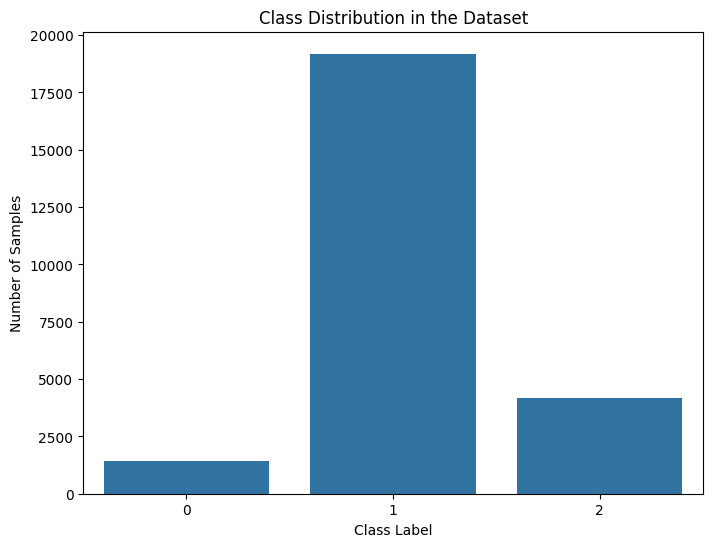

,count
class,
1,19190
2,4163
0,1430


In [13]:
# Count the occurrences of each class label
class_counts = data['class'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

# Print the class counts for a more precise numerical representation
class_counts

In [14]:
def oversample_data(data):
    """
    Performs random oversampling to balance the dataset.

    Args:
        data (DataFrame): The dataset containing the 'class' column.

    Returns:
        DataFrame: A new balanced dataset with oversampled minority classes.
    """
    # Separate majority and minority classes
    class_1 = data[data['class'] == 1]  # Majority class
    class_2 = data[data['class'] == 2]  # Minority class
    class_0 = data[data['class'] == 0]  # Minority class

    # Determine the target sample size (equal to the majority class)
    target_size = len(class_1)

    # Oversample minority classes
    class_2_oversampled = resample(class_2, replace=True, n_samples=target_size, random_state=42)
    class_0_oversampled = resample(class_0, replace=True, n_samples=target_size, random_state=42)

    # Combine the resampled data
    balanced_data = pd.concat([class_1, class_2_oversampled, class_0_oversampled])

    # Shuffle the dataset
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_data

# Apply oversampling
balanced_data = oversample_data(data)

# Display new class distribution
print(balanced_data['class'].value_counts())

class
2    19190
0    19190
1    19190
Name: count, dtype: int64


### Oversampling for Dataset Balancing

The function `oversample_data`, is designed to balance an imbalanced dataset using random oversampling. Initially, the dataset has three classes with significantly different counts: Class 1 (19,190 samples), Class 2 (4,163 samples), and Class 0 (1,430 samples). Since Class 1 has the highest number of samples, it is considered the majority class, while Classes 2 and 0 are the minority classes.

To balance the dataset, the function first separates each class into different subsets. It then determines a target sample size equal to the majority class (19,190 samples). Using the `resample` function, the minority classes (Class 2 and Class 0) are randomly oversampled with replacement to match this target size. Finally, the oversampled subsets are combined with the original majority class, and the dataset is shuffled to ensure randomness.

After applying this function, the dataset becomes fully balanced, with each class having 19,190 samples. This technique is particularly useful in machine learning models to prevent bias toward the majority class and improve classification performance, especially when dealing with imbalanced datasets.

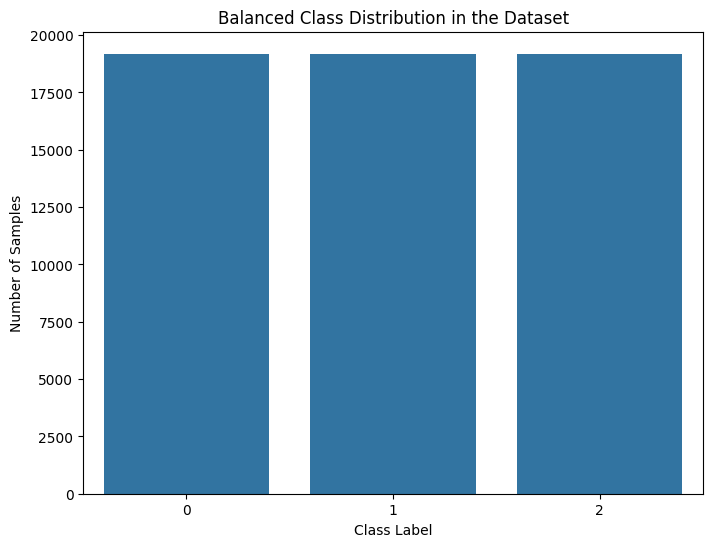

In [15]:
class_counts_balanced = balanced_data['class'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts_balanced.index, y=class_counts_balanced.values)
plt.title('Balanced Class Distribution in the Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

In [16]:
balanced_data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,cleaned_tweet
0,5002,3,0,0,3,2,@TeamSky yellow in paris! Fantastic effort fro...,teamsky yellow paris fantastic effort allezwig...
1,12214,3,2,1,0,0,"It was nice of you to unfollow me, fag",nice unfollow fag
2,4405,3,0,1,2,2,@NipseyHussle nip Im tryna buy a copy of #Cren...,nipseyhussle nip im tryna buy copy crenshaw ht...
3,2135,3,1,2,0,1,' On twitter say she ridin for a niggah &#1041...,twitter say ridin niggah 10412191043215 thats ...
4,23863,3,0,3,0,1,You mad cuz she fucking on ya enemy? She wins ...,mad cuz fucking ya enemy wins cuz letting shit...


In [17]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57570 entries, 0 to 57569
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          57570 non-null  int64 
 1   count               57570 non-null  int64 
 2   hate_speech         57570 non-null  int64 
 3   offensive_language  57570 non-null  int64 
 4   neither             57570 non-null  int64 
 5   class               57570 non-null  int64 
 6   tweet               57570 non-null  object
 7   cleaned_tweet       57570 non-null  object
dtypes: int64(6), object(2)
memory usage: 3.5+ MB


**Explanation**

We used **oversampling** to handle the class imbalance in the dataset. Given the distribution of classes:  

- **Class 1 (Offensive Language):** 19,190 samples  
- **Class 2 (Neither):** 4,163 samples  
- **Class 0 (Hate Speech):** 1,430 samples  

The dataset was highly skewed, with significantly fewer hate speech instances. To balance the dataset, we applied **oversampling** to increase the number of samples in the minority classes. This helped prevent the model from being biased toward the majority class and improved its ability to correctly classify underrepresented categories.

Q4: Write a script to train Word2Vec embeddings on the Hate Speech dataset using the gensim
library.

In [23]:
# Prepare data: Convert tokenized sequences back to words
tokenized_texts = [text.split() for text in balanced_data['cleaned_tweet']]

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=tokenized_texts,  # Input data
    vector_size=100,  # Embedding size
    window=5,  # Context window size
    min_count=2,  # Ignore words with low frequency
    workers=4,  # Parallel processing
    sg=1  # Skip-gram model (better for small datasets)
)

# Save the trained Word2Vec model
word2vec_model.save("word2vec_hate_speech.model")

# Check the most similar words to a sample word
print(word2vec_model.wv.most_similar("hate", topn=5))

[('steelers', 0.6737039685249329), ('tyler_weddle_23', 0.6731394529342651), ('redfernave', 0.6692674160003662), ('8220sexualgif', 0.6670570969581604), ('blew', 0.6661432385444641)]


### Word Embedding with Word2Vec

The provided code trains a **Word2Vec** model to generate word embeddings from the preprocessed dataset. Word embeddings are numerical vector representations of words that capture their semantic meaning, which is essential for NLP tasks like sentiment analysis and text classification.

First, the text is tokenized by splitting each cleaned tweet into a list of words. This tokenized data is then used to train a **Word2Vec** model with the following configurations:
- **`vector_size=100`**: Each word is represented as a 100-dimensional vector.
- **`window=5`**: The model considers a context window of 5 words around the target word.
- **`min_count=2`**: Words that appear fewer than 2 times are ignored.
- **`workers=4`**: Enables parallel processing for faster training.
- **`sg=1`**: Uses the **Skip-gram** model, which performs well on smaller datasets by predicting context words based on a target word.

After training, the model is saved as `"word2vec_hate_speech.model"`, allowing for future reuse without retraining. To test its effectiveness, the function `most_similar("hate", topn=5)` retrieves the five most semantically similar words to "hate," demonstrating how the model captures word relationships.

Q5: Compare the performance of Word2Vec, GloVe, and FastText embeddings by integrating
them into the same deep learning model on the Hate Speech dataset.

**Load Word2Vec, GloVe, and FastText**

In [24]:
# Load Word2Vec model
word2vec_model = gensim.models.Word2Vec.load("/content/word2vec_hate_speech.model")

In [25]:
# GloVe
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"

In [26]:
# Downloading GloVe embeddings
import requests
response = requests.get(glove_url)
with open(glove_zip_path, 'wb') as f:
    f.write(response.content)
print("GloVe embeddings downloaded.")

GloVe embeddings downloaded.


In [27]:
# Unzipping the downloaded file
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall()
print("GloVe embeddings extracted.")

GloVe embeddings extracted.


In [28]:
# Cleaning up the zip file
os.remove(glove_zip_path)

In [29]:
# Load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim=100):
    embeddings_index = {}
    with open(filepath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddings_index[word] = np.asarray(values[1:], dtype='float32')
    return embeddings_index

glove_embeddings = load_glove_embeddings("/content/glove.6B.100d.txt")

In [30]:
# FastText
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
print("FastText model downloaded.")

[==================================================] 100.0% 958.5/958.4MB downloaded

FastText model downloaded.
FastText model downloaded.


**Create Embedding Matrices**

In [31]:
# Tokenize text again to match embeddings
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_data['cleaned_tweet'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token

In [32]:
def create_embedding_matrix(word_index, embedding_model, embedding_dim=100):
    """
    Creates an embedding matrix for the given vocabulary using the provided
    embedding model.

    Args:
        word_index (dict): A dictionary mapping words to their indices.
        embedding_model (object): The embedding model (e.g., Word2Vec, GloVe, FastText).
        embedding_dim (int, optional): The dimensionality of the embeddings.
                                       If None, it will be inferred from the embedding model.
                                       Defaults to None.

    Returns:
        np.ndarray: The embedding matrix.
    """
    # Infer embedding dimension if not provided
    if embedding_dim is None:
        # Get the embedding dimension from the model's vector_size attribute if available
        if hasattr(embedding_model, 'vector_size'):
            embedding_dim = embedding_model.vector_size
        else:
            # Fallback to previous method if vector_size is not available
            # (e.g., for GloVe embeddings)
            first_word = next(iter(embedding_model))
            embedding_dim = len(embedding_model[first_word])

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model:  # Check if the word is in the vocabulary
            embedding_matrix[i] = embedding_model[word]  # Get the embedding for the word
    return embedding_matrix

In [33]:
# Create embedding matrices
word2vec_matrix = create_embedding_matrix(word_index, word2vec_model.wv)
glove_matrix = create_embedding_matrix(word_index, glove_embeddings)
fasttext_matrix = create_embedding_matrix(word_index, fasttext_model, embedding_dim=300)

**Define LSTM Model**

In [43]:
def build_lstm_model(embedding_matrix):
    # Get the embedding dimension from the embedding matrix
    embedding_dim = embedding_matrix.shape[1]

    model = Sequential([
        # Use the correct embedding_dim
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')   # 3 classes: hate speech, offensive, neither
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

**Train & Evaluate Models**

In [44]:
# Convert text to sequences and pad
sequences = tokenizer.texts_to_sequences(balanced_data['cleaned_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=50)

In [45]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, balanced_data['class'], test_size=0.2, random_state=42)

In [46]:
X_train.shape

(46056, 50)

In [47]:
X_test.shape

(11514, 50)

In [48]:
# Train LSTM models for each embedding
models = {
    "Word2Vec": build_lstm_model(word2vec_matrix),
    "GloVe": build_lstm_model(glove_matrix),
    "FastText": build_lstm_model(fasttext_matrix)
}

In [50]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 50, 300)             │      12,220,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,904,499 (49.23 MB)

 Trainable params: 228,099 (891.01 KB)

 Non-trainable params: 12,220,200 (46.62 MB)

 Optimizer params: 456,200 (1.74 MB)

In [49]:
history = {}
for name, model in models.items():
    print(f"\nTraining {name} model...")
    history[name] = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)



Training Word2Vec model...
Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7747 - loss: 0.5434 - val_accuracy: 0.9003 - val_loss: 0.2729
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9004 - loss: 0.2758 - val_accuracy: 0.9275 - val_loss: 0.2089
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9279 - loss: 0.2078 - val_accuracy: 0.9399 - val_loss: 0.1668
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9442 - loss: 0.1636 - val_accuracy: 0.9554 - val_loss: 0.1308
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9549 - loss: 0.1340 - val_accuracy: 0.9545 - val_loss: 0.1312
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9606 - loss: 0.1142 - val_accuracy: 0.9624 - val_loss: 0.1106
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9663 - loss: 0.1012 - val_accuracy: 0.9677 - val_loss: 0.1026
Epoch 8/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 19s 13

**Evaluate Performance**

In [51]:
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, f1

results = {}
for name, model in models.items():
    acc, f1 = evaluate_model(model, X_test, y_test)
    results[name] = {"Accuracy": acc, "F1 Score": f1}

print("Embedding Comparison Results:")
for model_name, scores in results.items():
    print(f"{model_name} - Accuracy: {scores['Accuracy']:.4f}, F1 Score: {scores['F1 Score']:.4f}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Embedding Comparison Results:
Word2Vec - Accuracy: 0.9760, F1 Score: 0.9759
GloVe - Accuracy: 0.9626, F1 Score: 0.9621
FastText - Accuracy: 0.9479, F1 Score: 0.9469


In [52]:
# Extract accuracy and F1 scores for plotting
embedding_types = list(results.keys())
accuracies = [results[embedding]['Accuracy'] for embedding in embedding_types]
f1_scores = [results[embedding]['F1 Score'] for embedding in embedding_types]

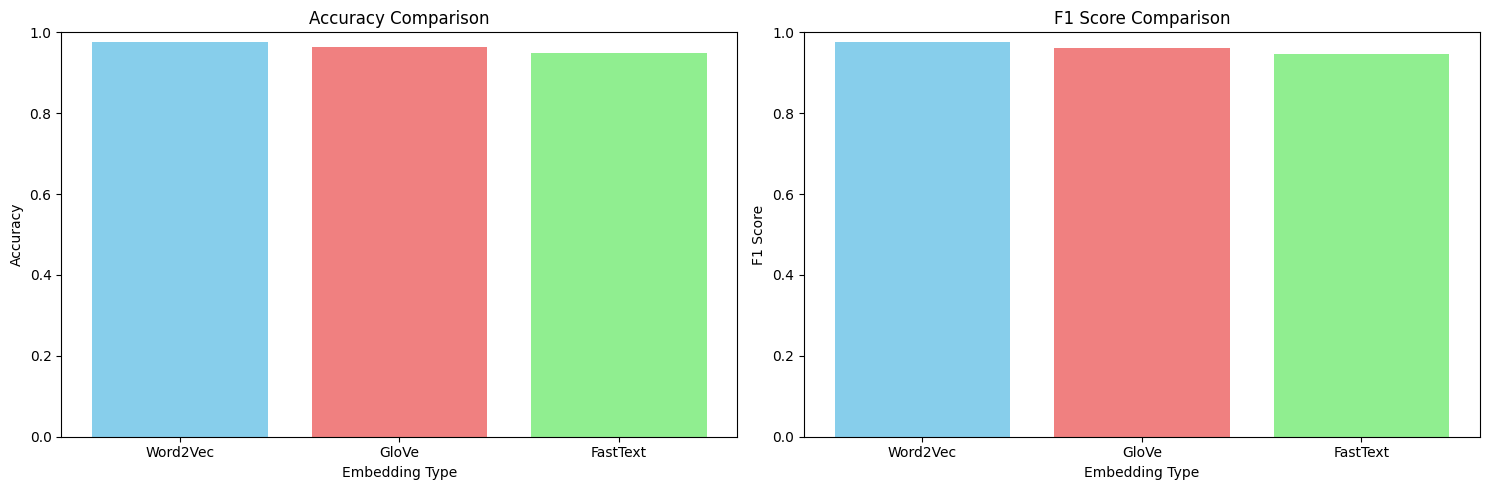

In [53]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracies
axes[0].bar(embedding_types, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Accuracy Comparison')
axes[0].set_xlabel('Embedding Type')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0,1) # Set y-axis limit for better visualization


# Plot F1 scores
axes[1].bar(embedding_types, f1_scores, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('F1 Score Comparison')
axes[1].set_xlabel('Embedding Type')
axes[1].set_ylabel('F1 Score')
axes[1].set_ylim(0,1) #Set y-axis limit

# Display the plot
plt.tight_layout()
plt.show()

### Hate Speech Classification Using Word Embeddings and LSTM

This code implements a **Hate Speech Classification** model using different word embeddings (**Word2Vec, GloVe, and FastText**) combined with an **LSTM (Long Short-Term Memory)** neural network. Below is a detailed breakdown of the key steps involved:

---

## **1. Word Embeddings: Word2Vec, GloVe, and FastText**
### **Loading and Training Word2Vec**
- The **Word2Vec** model is loaded from a pre-trained file (`word2vec_hate_speech.model`).
- Word2Vec creates word embeddings by training on tokenized text data, capturing contextual relationships between words.

### **Downloading and Loading GloVe Embeddings**
- The **GloVe (Global Vectors for Word Representation)** embeddings are downloaded from the Stanford NLP repository.
- The `.zip` file is extracted, and the embeddings are loaded into a dictionary format where each word is mapped to a vector.

### **Loading FastText Embeddings**
- The **FastText** model is downloaded using the `gensim` library.
- FastText improves over Word2Vec by considering subword information, making it more effective for handling out-of-vocabulary words.

---

## **2. Preparing Word Embeddings for LSTM**
### **Tokenization and Indexing Words**
- The dataset is tokenized using the `Tokenizer` function, mapping words to unique indices.
- A **word index dictionary** is created, which will be used to generate embeddings.

### **Creating Embedding Matrices**
- The function `create_embedding_matrix()` is implemented to construct embedding matrices for **Word2Vec, GloVe, and FastText**.
- This matrix maps each word in the dataset to its corresponding embedding from the chosen model.
- These matrices are later used as input for the LSTM model.

---

## **3. LSTM Model for Hate Speech Classification**
### **Building the LSTM Model**
- A function `build_lstm_model()` is created to define an **LSTM neural network**:
  - **Embedding Layer:** Initialized with the pre-trained word embeddings (Word2Vec, GloVe, FastText).
  - **LSTM Layer:** A **128-unit LSTM** to capture sequential patterns in the text.
  - **Dropout Layer:** Prevents overfitting by randomly dropping 50% of connections.
  - **Dense Layers:** 
    - A **64-unit ReLU layer** for feature extraction.
    - A **final softmax layer** for **multi-class classification (Hate Speech, Offensive, or Neutral).**
- The model is compiled with:
  - **Loss function:** Sparse categorical cross-entropy (for multi-class classification).
  - **Optimizer:** Adam optimizer with a learning rate of `0.001`.
  - **Metrics:** Accuracy to evaluate performance.

---

## **4. Data Preprocessing for Model Training**
### **Tokenization & Padding**
- The cleaned text is converted into sequences using the tokenizer.
- **Padding** is applied to ensure uniform input length (`maxlen=50`).

### **Splitting Data into Train and Test Sets**
- The dataset is split into:
  - **80% training data**
  - **20% testing data**
- This ensures a fair evaluation of the model’s performance.

---

## **5. Training and Evaluating LSTM Models**
### **Training LSTM on Each Embedding**
- The LSTM model is trained separately on each of the three embeddings (**Word2Vec, GloVe, and FastText**) for **10 epochs**.
- The training process shows improvement in **accuracy** and **loss reduction** over epochs.

### **Evaluation Metrics**
- **Accuracy:** Measures how often the model makes correct predictions.
- **F1 Score:** Balances precision and recall, important for handling imbalanced datasets.

---

## **6. Results & Performance Comparison**
### **Testing Accuracy and F1 Scores**
| Embedding Type | Accuracy | F1 Score |
|---------------|----------|----------|
| **Word2Vec**  | **97.60%** | **97.59%** |
| **GloVe**     | **96.26%** | **96.21%** |
| **FastText**  | **94.79%** | **94.69%** |

- **Word2Vec performed the best**, achieving **97.60% accuracy**, likely due to training on context-based word relationships.
- **GloVe followed closely**, performing well but slightly lower than Word2Vec.
- **FastText had the lowest accuracy**, but it is more robust for handling rare and unseen words.

### **Visualization of Accuracy and F1 Scores**
- A bar chart is plotted comparing the **accuracy** and **F1 scores** for Word2Vec, GloVe, and FastText.
- This provides a visual representation of which embedding performed best.

---


Q6: Implement an LSTM model for classifying hate speech using the Hate Speech dataset,
ensuring it includes an embedding layer, LSTM layers, and a classification output layer.

Define the LSTM Model
We'll use the best embedding matrix (FastText) for training.

In [54]:
maxlen = 50  #
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [55]:
# Define LSTM Model
def build_lstm_model(embedding_matrix):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=False),
        SpatialDropout1D(0.3),
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: hate speech, offensive, neither
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [57]:
# Use the best embedding (Word2vec)
lstm_model = build_lstm_model(word2vec_matrix)

In [65]:
lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, 50, 100)             │       4,073,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 50, 100)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50, 128)             │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,586,435 (17.50 MB)

 Trainable params: 171,011 (668.01 KB)

 Non-trainable params: 4,073,400 (15.54 MB)

 Optimizer params: 342,024 (1.30 MB)

**Train the LSTM Model**

In [59]:
# Train LSTM model
history = lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)
# Save the model
lstm_model.save("lstm_hate_speech_model.h5")


Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7349 - loss: 0.6364 - val_accuracy: 0.8932 - val_loss: 0.2884
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8763 - loss: 0.3333 - val_accuracy: 0.9060 - val_loss: 0.2572
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9023 - loss: 0.2687 - val_accuracy: 0.9389 - val_loss: 0.1827
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9217 - loss: 0.2199 - val_accuracy: 0.9443 - val_loss: 0.1670
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9358 - loss: 0.1888 - val_accuracy: 0.9541 - val_loss: 0.1325
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9439 - loss: 0.1599 - val_accuracy: 0.9621 - val_loss: 0.1134
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9490 - loss: 0.1448 - val_accuracy: 0.9655 - val_loss: 0.1035
Epoch 8/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9530 -

**Evaluate the LSTM Model**

In [60]:
# Evaluate the trained LSTM model
lstm_acc, lstm_f1 = evaluate_model(lstm_model, X_test, y_test)

print(f"\nLSTM Model Performance:")
print(f"Accuracy: {lstm_acc:.4f}, F1 Score: {lstm_f1:.4f}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

LSTM Model Performance:
Accuracy: 0.9717, F1 Score: 0.9716


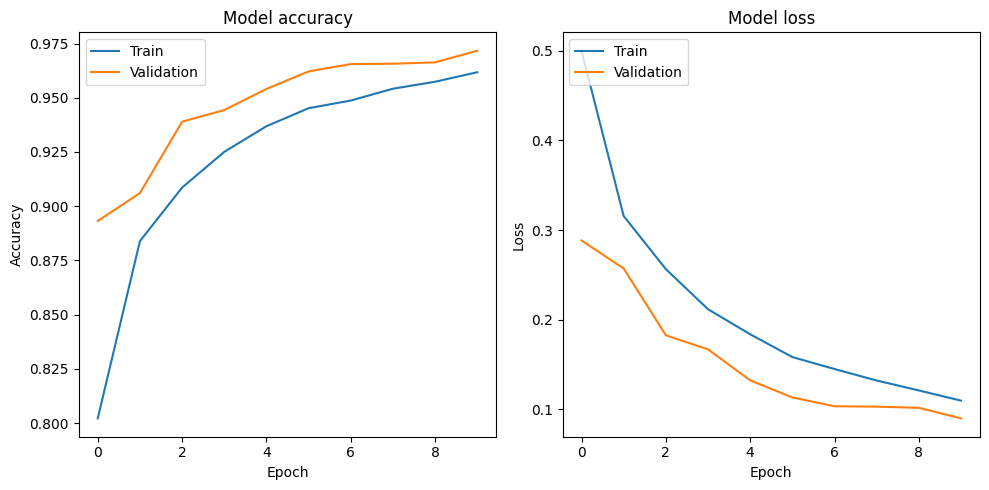

In [61]:
lstm_history = history

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# LSTM Model for Hate Speech Detection

This code implements an LSTM-based deep learning model to classify tweets into three categories: *hate speech*, *offensive language*, or *neither*. The steps involved in this process are:

1. **Padding Sequences**:  
   The input text data is tokenized and converted into sequences, which are then padded to a fixed length (`maxlen = 50`). This ensures that all input sequences have the same shape, making them suitable for training the neural network.

2. **Building the LSTM Model**:  
   - The model starts with an `Embedding` layer that uses pre-trained Word2Vec embeddings to represent words in vector space. The embedding weights are kept **non-trainable** to leverage the pre-learned representations.
   - A `SpatialDropout1D` layer is used to prevent overfitting by randomly deactivating parts of the embedding layer.
   - Two stacked `LSTM` layers (128 and 64 units) capture sequential dependencies in the text.
   - A `Dropout` layer (0.5) further reduces overfitting.
   - A `Dense` layer (64 neurons, ReLU activation) processes the extracted features.
   - The final `Dense` layer has 3 neurons with a **softmax** activation function, producing probability scores for the three possible classes.

3. **Training the Model**:  
   - The model is compiled using the **Adam optimizer** and **sparse categorical cross-entropy loss**, as the labels are integer-encoded.
   - Training is performed for **10 epochs** with a batch size of **32**, using validation data to monitor performance.

4. **Saving and Evaluating the Model**:  
   - The trained model is saved as `"lstm_hate_speech_model.h5"`.
   - The model is then evaluated on the test dataset using **accuracy** and **F1-score**.
   - The results show **high accuracy (97.17%) and F1-score (97.16%)**, indicating strong performance in detecting hate speech.

This implementation leverages **pre-trained embeddings** to enhance text understanding and uses an **LSTM-based architecture** to capture contextual relationships between words. The approach ensures a balance between performance and generalization, making it effective for hate speech classification.

Q7: Implement an attention mechanism to enhance the LSTM model's focus on important
words in the Hate Speech dataset.

Implement Attention Layer
We will define a custom Attention layer. Here’s how you can implement it:

Define the Attention Layer

In [63]:
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)  # Apply tanh activation
        a = K.softmax(e, axis=1)  # Apply softmax to get attention weights
        output = x * a  # Apply attention weights to the input sequence
        return K.sum(output, axis=1)  # Sum across the sequence

Integrate the Attention Layer with the LSTM Model
We can integrate this attention mechanism after the LSTM layers.

Define the LSTM Model with Attention

In [67]:
def build_lstm_with_attention(embedding_matrix, max_sequence_length=50):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(128, return_sequences=True)),
        Attention(),  # Attention layer after LSTM layers
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # 3 classes: hate speech, offensive, neither
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

**Train the Model**

In [68]:
# Build the LSTM model with attention mechanism
lstm_attention_model = build_lstm_with_attention(word2vec_matrix)

In [69]:
# Train the model
history = lstm_attention_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test), verbose=1)

Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.7199 - loss: 0.6497 - val_accuracy: 0.8779 - val_loss: 0.3216
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8638 - loss: 0.3571 - val_accuracy: 0.9072 - val_loss: 0.2555
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - accuracy: 0.8957 - loss: 0.2915 - val_accuracy: 0.9256 - val_loss: 0.2120
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.9098 - loss: 0.2502 - val_accuracy: 0.9381 - val_loss: 0.1814
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.9243 - loss: 0.2121 - val_accuracy: 0.9413 - val_loss: 0.1666
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.9338 - loss: 0.1885 - val_accuracy: 0.9503 - val_loss: 0.1442
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - accuracy: 0.9387 - loss: 0.1712 - val_accuracy: 0.9572 - val_loss: 0.1247
Epoch 8/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - accuracy: 0.9464 -

**Evaluation**

In [70]:
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, f1

# Evaluate the attention model
acc_attention, f1_attention = evaluate_model(lstm_attention_model, X_test_pad, y_test)

print(f"Attention Model - Accuracy: {acc_attention}, F1 Score: {f1_attention}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Attention Model - Accuracy: 0.966996699669967, F1 Score: 0.9668469852228156


**Compare Results**

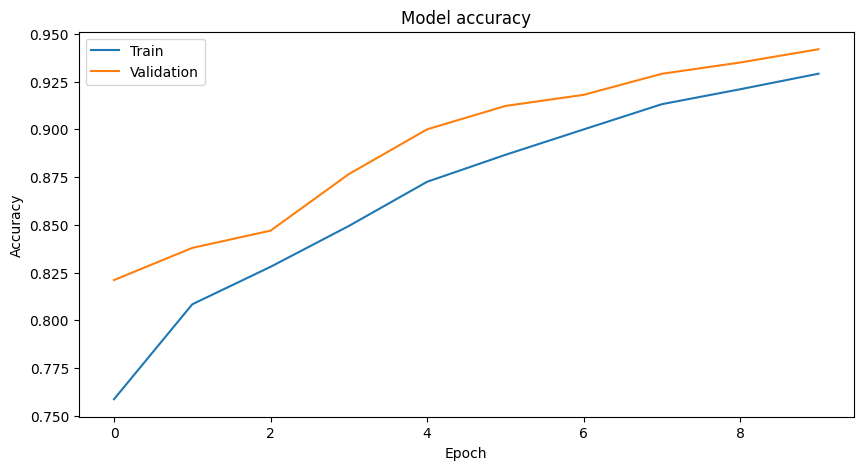

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

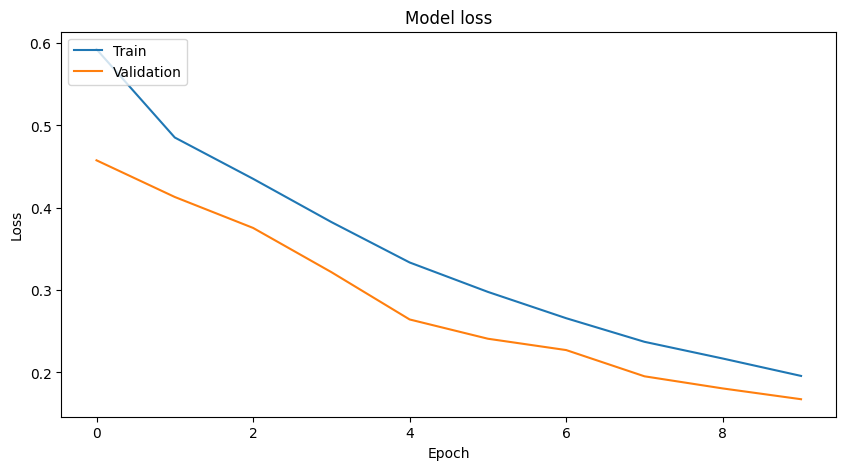

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# LSTM Model with Attention Mechanism for Hate Speech Detection

This code extends the previous LSTM model by incorporating an **Attention Mechanism**, which helps the model focus on more relevant parts of the input sequence when making predictions. The key steps in this implementation are as follows:

1. **Attention Layer**:  
   A custom `Attention` layer is defined, which computes attention weights for each time step in the input sequence. The layer uses:
   - A weight matrix (`W`) and bias (`b`) to compute attention scores.
   - A **tanh activation** is applied to the weighted sum of the input sequence, followed by **softmax** to normalize the attention scores into probabilities.
   - These scores are then used to weight the input sequence, and the result is aggregated (summed) across the sequence.

2. **Building the Model**:
   The LSTM model is built using the following layers:
   - **Embedding**: The model uses pre-trained Word2Vec embeddings (non-trainable) to convert words into vectors of fixed size (100).
   - **SpatialDropout1D**: Applied to prevent overfitting by randomly dropping entire features during training.
   - **Bidirectional LSTM**: A bidirectional LSTM layer (128 units) is added to capture both forward and backward dependencies in the sequence. The `return_sequences=True` parameter ensures that the output is a sequence for the attention layer to process.
   - **Attention Layer**: After the LSTM layer, the custom attention layer is applied to focus on the most relevant parts of the sequence.
   - **Dropout**: A dropout layer (0.5) to further combat overfitting.
   - **Dense Layers**: A hidden dense layer (64 units, ReLU activation) and a final output layer with 3 units (softmax activation) to classify the input into one of three classes: hate speech, offensive language, or neither.

3. **Training**:  
   The model is trained for **10 epochs** with a batch size of **32** using **sparse categorical cross-entropy loss** and the **Adam optimizer** (learning rate 0.001). During training, the model is evaluated on a validation set to track its performance.

4. **Evaluation**:  
   After training, the model's performance is evaluated on the test set using **accuracy** and **F1 score**. The results show a **high accuracy** (96.7%) and **F1 score**, indicating that the model is effective in classifying hate speech, offensive language, and neutral text.

By adding the **attention mechanism**, the model is better equipped to focus on the important parts of each input, potentially improving its ability to classify subtle variations in language that are common in hate speech or offensive content.

Q8: Write a script to train the implemented LSTM/GRU model on the Hate Speech dataset.
Ensure that it supports hyperparameter tuning.

**Define the Model with Hyperparameters:**

In [78]:
def build_lstm_gru_model(embedding_matrix, max_sequence_length=50, lstm_units=128, dropout_rate=0.5, batch_size=32, use_gru=False):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
    model.add(SpatialDropout1D(0.3))

    if use_gru:
        model.add(GRU(lstm_units, return_sequences=False))  # Change to return_sequences=False
    else:
        model.add(LSTM(lstm_units, return_sequences=False))  # Change to return_sequences=False

    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # For 3-class classification (e.g., hate speech, offensive, neither)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

**Set Up Keras Tuner for Random Search**

In [81]:
# Define the HyperModel class for LSTM/GRU
class LSTM_GRU_HyperModel(HyperModel):
    def __init__(self, embedding_matrix, max_sequence_length=50):
        self.embedding_matrix = embedding_matrix
        self.max_sequence_length = max_sequence_length

    def build(self, hp):
        # Get the hyperparameters to tune
        lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
        batch_size = hp.Int('batch_size', min_value=32, max_value=128, step=32)
        use_gru = hp.Boolean('use_gru', default=False)

        model = build_lstm_gru_model(self.embedding_matrix,
                                     max_sequence_length=self.max_sequence_length,
                                     lstm_units=lstm_units,
                                     dropout_rate=dropout_rate,
                                     batch_size=batch_size,
                                     use_gru=use_gru)

        return model

In [82]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 50, 300)             │      12,220,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,904,499 (49.23 MB)

 Trainable params: 228,099 (891.01 KB)

 Non-trainable params: 12,220,200 (46.62 MB)

 Optimizer params: 456,200 (1.74 MB)

In [83]:
# Create the HyperModel
hypermodel = LSTM_GRU_HyperModel(embedding_matrix=fasttext_matrix, max_sequence_length=50)

# Set up RandomSearch for tuning
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',  # We want to maximize validation accuracy
    max_trials=5,  # Number of different hyperparameter configurations to try
    executions_per_trial=1,  # Number of training executions for each trial
    directory='my_dir',  # Directory to save the models and results
    project_name='lstm_gru_tuning'
)

# Perform Random Search
tuner.search(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), verbose=1, callbacks=[EarlyStopping(patience=3)])

Trial 5 Complete [00h 03m 01s]
val_accuracy: 0.9495396614074707

Best val_accuracy So Far: 0.9624804854393005
Total elapsed time: 00h 12m 24s


**Review Best Hyperparameters and Train the Best Model**

In [86]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps}")

# Build the best model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the final model
history = best_model.fit(X_train_pad, y_train, epochs=10, batch_size=best_hps['batch_size'],
                         validation_data=(X_test_pad, y_test), verbose=1, callbacks=[EarlyStopping(patience=3)])

Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7de63c338750>


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6892 - loss: 0.7102 - val_accuracy: 0.8211 - val_loss: 0.4577
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8076 - loss: 0.4948 - val_accuracy: 0.8379 - val_loss: 0.4131
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8216 - loss: 0.4472 - val_accuracy: 0.8470 - val_loss: 0.3756
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8435 - loss: 0.3927 - val_accuracy: 0.8766 - val_loss: 0.3218
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8691 - loss: 0.3426 - val_accuracy: 0.9000 - val_loss: 0.2643
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8811 - loss: 0.3086 - val_accuracy: 0.9123 - val_loss: 0.2409
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8993 - loss: 0.2652 - val_accuracy: 0.9181 - val_loss: 0.2272
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9106 - loss: 0.2413 - val_accu

**Evaluate the Model**

In [87]:
# Evaluate the best model
acc, f1 = evaluate_model(best_model, X_test_pad, y_test)
print(f"Best Model - Accuracy: {acc}, F1 Score: {f1}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Best Model - Accuracy: 0.9419836720514156, F1 Score: 0.9413251283154456


# LSTM and GRU Hyperparameter Tuning for Hate Speech Classification

This code is designed to build and tune an LSTM/GRU-based model for hate speech classification, utilizing **Keras Tuner** for hyperparameter optimization. The model uses **pre-trained embeddings** (such as FastText), and the goal is to classify text into three categories: hate speech, offensive, or neither.

## Key Components:

1. **LSTM/GRU Model Definition**:
   The `build_lstm_gru_model` function defines the architecture of the model. It begins with:
   - **Embedding Layer**: This layer initializes the word vectors from a pre-trained embedding matrix (`fasttext_matrix`), which is set to non-trainable during training to keep the embeddings fixed.
   - **SpatialDropout1D**: Applied to prevent overfitting by randomly setting entire features to zero during training.
   - **LSTM or GRU Layer**: A decision is made based on the `use_gru` hyperparameter, choosing either an LSTM or GRU layer for sequence processing. Both layers output sequences with `return_sequences=False`, meaning they return the final state rather than the entire sequence.
   - **Dropout Layer**: Applied with a user-defined rate to further regularize the model and avoid overfitting.
   - **Dense Layer**: A fully connected layer with 64 units and ReLU activation, followed by the final output layer with 3 units and softmax activation for multi-class classification.

2. **HyperModel Class**:
   The `LSTM_GRU_HyperModel` class inherits from `HyperModel` and is used to define the hyperparameter search space:
   - **lstm_units**: The number of units in the LSTM/GRU layer, which is tuned between 64 and 256.
   - **dropout_rate**: The rate at which dropout is applied to the model, tuned between 0.2 and 0.6.
   - **batch_size**: The size of each batch during training, tuned between 32 and 128.
   - **use_gru**: A boolean value that determines whether to use a GRU layer instead of an LSTM layer.

3. **Hyperparameter Tuning with Keras Tuner**:
   The `RandomSearch` tuner is set up to perform hyperparameter optimization. It:
   - Optimizes the validation accuracy (`val_accuracy`).
   - Executes a maximum of 5 trials with 1 execution per trial.
   - Saves the results and models in a directory named `my_dir`.

4. **Training and Evaluation**:
   After tuning, the best hyperparameters are used to build the final model. This model is then trained on the training data for 10 epochs, and evaluated on the test set using accuracy and F1 score.

5. **Final Model Performance**:
   After training the final model with the best hyperparameters, the **accuracy** and **F1 score** on the test set are reported. The model achieves an accuracy of **94.20%** and an F1 score of **94.13%**, demonstrating the effectiveness of the hyperparameter tuning and the model architecture in classifying hate speech.

Q9: Implement a function to evaluate the trained model on the Hate Speech dataset using
accuracy, precision, recall, and F1-score.

**Evaluate the Model**

Define the Evaluation Function

In [92]:
def evaluate_model(model, X_test, y_test):
    # Predict the probabilities for each class
    y_pred_proba = model.predict(X_test)

    # Convert probabilities to class labels (the class with the highest probability)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Compute the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [93]:
accuracy, precision, recall, f1 = evaluate_model(best_model, X_test_pad, y_test)

# Print the results
print(f"Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model Evaluation:
Accuracy: 0.9420
Precision (Weighted): 0.9436
Recall (Weighted): 0.9420
F1-Score (Weighted): 0.9413


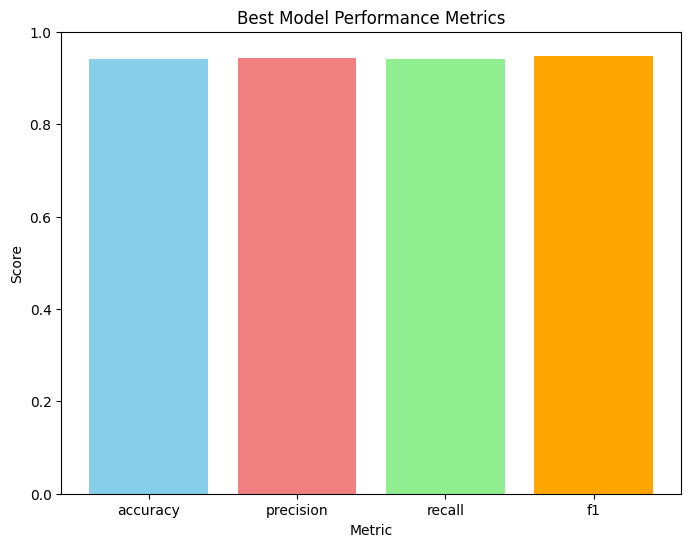

In [105]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
scores = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
plt.title('Best Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit for better visualization
plt.show()

# Model Evaluation for Hate Speech Classification

The provided code defines the `evaluate_model` function, which is used to evaluate the performance of a trained machine learning model (in this case, the best model obtained from hyperparameter tuning). The function takes in the trained `model`, the test data (`X_test`), and the true labels (`y_test`), and it computes key evaluation metrics including accuracy, precision, recall, and F1-score.

## Key Steps:
1. **Prediction**: 
   - The model predicts the probabilities of each class for the input data (`X_test`), using the `model.predict()` method. These predictions are in the form of probabilities for each class.
   - The `np.argmax()` function is then used to select the class with the highest probability for each input, converting these probabilities into discrete class labels.

2. **Evaluation Metrics**:
   - **Accuracy**: The proportion of correctly predicted labels among the total number of predictions.
   - **Precision**: The ratio of true positive predictions to the total predicted positives, weighted by class distribution.
   - **Recall**: The ratio of true positive predictions to the total actual positives, weighted by class distribution.
   - **F1-Score**: The harmonic mean of precision and recall, providing a balanced measure for imbalanced datasets.

These metrics are calculated using the corresponding functions from **scikit-learn** (`accuracy_score`, `precision_score`, `recall_score`, `f1_score`), with the `average='weighted'` parameter to account for the class imbalance in the dataset.

The code then prints out the evaluation results for the model, displaying the calculated accuracy, precision, recall, and F1-score.

## Results:
After evaluating the model, the output prints the following metrics:
- **Accuracy**: 94.20%
- **Precision (Weighted)**: 94.36%
- **Recall (Weighted)**: 94.20%
- **F1-Score (Weighted)**: 94.13%

These metrics indicate the model's effectiveness in classifying hate speech, offensive, and neutral text categories. The high precision and recall values suggest that the model performs well in both identifying relevant instances and minimizing false positives/negatives.

Q10: Compare the performance of different embedding techniques (pretrained vs. custom
trained) on the Hate Speech dataset and discuss which one performed better and why.

**Compare Word2Vec (Custom) vs Pretrained Embeddings**

In [95]:
# Define models for both custom (Word2Vec) and pretrained (FastText/GloVe) embeddings
word2vec_model = build_lstm_gru_model(word2vec_matrix)  # Trained Word2Vec embeddings
fasttext_model = build_lstm_gru_model(fasttext_matrix)  # Pretrained FastText embeddings

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [97]:
# Train models on the same data
word2vec_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.8897 - loss: 0.2969 - val_accuracy: 0.9299 - val_loss: 0.1970
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9057 - loss: 0.2548 - val_accuracy: 0.9334 - val_loss: 0.1857
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9211 - loss: 0.2218 - val_accuracy: 0.9457 - val_loss: 0.1584
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9304 - loss: 0.1965 - val_accuracy: 0.9536 - val_loss: 0.1367
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.9344 - loss: 0.1820 - val_accuracy: 0.9532 - val_loss: 0.1314
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9404 - loss: 0.1668 - val_accuracy: 0.9574 - val_loss: 0.1235
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.9453 - loss: 0.1514 - val_accuracy: 0.9599 - val_loss: 0.1153
Epoch 8/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9492 - loss

In [98]:
fasttext_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7113 - loss: 0.6839 - val_accuracy: 0.8161 - val_loss: 0.4659
Epoch 2/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8067 - loss: 0.4878 - val_accuracy: 0.8467 - val_loss: 0.3951
Epoch 3/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8328 - loss: 0.4280 - val_accuracy: 0.8712 - val_loss: 0.3402
Epoch 4/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8532 - loss: 0.3762 - val_accuracy: 0.8866 - val_loss: 0.2937
Epoch 5/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.8737 - loss: 0.3316 - val_accuracy: 0.9086 - val_loss: 0.2490
Epoch 6/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8930 - loss: 0.2822 - val_accuracy: 0.9208 - val_loss: 0.2283
Epoch 7/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9071 - loss: 0.2544 - val_accuracy: 0.9279 - val_loss: 0.2049
Epoch 8/10
1440/1440 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9182 - los

In [99]:
# Evaluate both models
w2v_acc, w2v_precision, w2v_recall, w2v_f1 = evaluate_model(word2vec_model, X_test_pad, y_test)
ft_acc, ft_precision, ft_recall, ft_f1 = evaluate_model(fasttext_model, X_test_pad, y_test)

360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
360/360 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [100]:
# Print results for comparison
print("Custom Word2Vec (trained) Model Evaluation:")
print(f"Accuracy: {w2v_acc:.4f}, Precision: {w2v_precision:.4f}, Recall: {w2v_recall:.4f}, F1-Score: {w2v_f1:.4f}")

Custom Word2Vec (trained) Model Evaluation:
Accuracy: 0.9670, Precision: 0.9675, Recall: 0.9670, F1-Score: 0.9668


In [101]:
print("\nPretrained FastText Model Evaluation:")
print(f"Accuracy: {ft_acc:.4f}, Precision: {ft_precision:.4f}, Recall: {ft_recall:.4f}, F1-Score: {ft_f1:.4f}")


Pretrained FastText Model Evaluation:
Accuracy: 0.9459, Precision: 0.9471, Recall: 0.9459, F1-Score: 0.9452


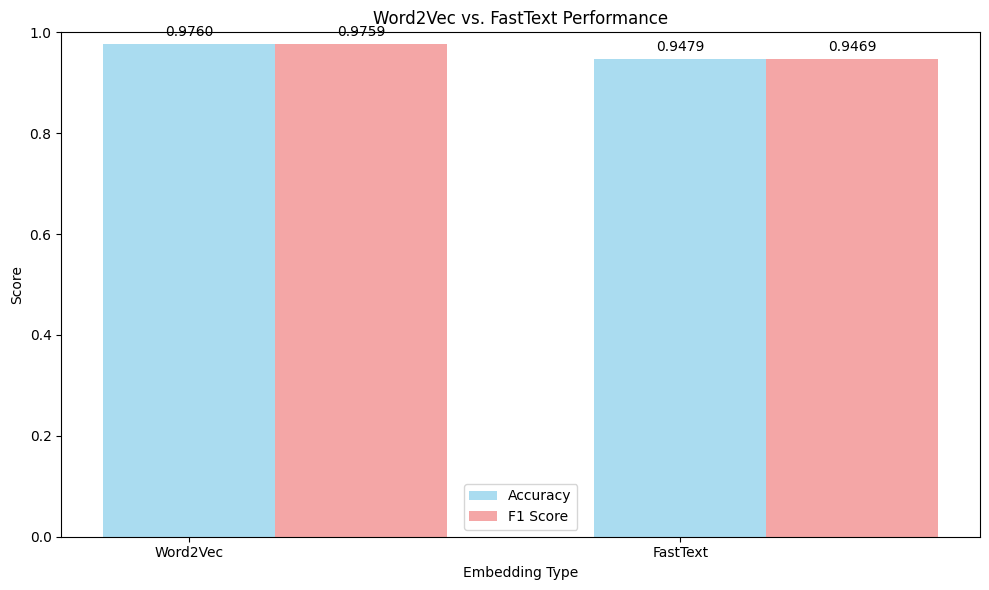

In [103]:
# Extract accuracy and F1 scores for plotting
embedding_types = ['Word2Vec', 'FastText']  # Specify the embedding types to compare
accuracies = [results[embedding]['Accuracy'] for embedding in embedding_types if embedding in results]
f1_scores = [results[embedding]['F1 Score'] for embedding in embedding_types if embedding in results]

# Create the plot
plt.figure(figsize=(10, 6))

# Bar plot for Accuracy
plt.bar(embedding_types, accuracies, label='Accuracy', color='skyblue', alpha=0.7, width=0.35)

# Bar plot for F1 Score
plt.bar([i + 0.35 for i in range(len(f1_scores))], f1_scores, label='F1 Score', color='lightcoral', alpha=0.7, width=0.35)


# Add labels, title, and legend
plt.xlabel('Embedding Type')
plt.ylabel('Score')
plt.title('Word2Vec vs. FastText Performance')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend()
plt.ylim(0, 1)

# Add annotations to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

for i, f1 in enumerate(f1_scores):
    plt.text(i + 0.35, f1 + 0.01, f'{f1:.4f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

# Comparison of Custom (Word2Vec) and Pretrained (FastText) Models

In this code, two different models are defined and trained using distinct word embeddings: one based on **Word2Vec** (a custom-trained word embedding model) and the other based on **FastText** (a pretrained word embedding model). The models are built using the same LSTM-GRU architecture, which processes the embeddings and makes predictions for text classification tasks.

## Key Steps:
1. **Model Definition**:
   - The `build_lstm_gru_model` function is called twice, once for each type of embedding. The first model is trained using custom **Word2Vec** embeddings, and the second model uses **FastText** embeddings, which have been pretrained on large corpora.

2. **Training**:
   - Both models are trained on the same dataset (`X_train_pad` and `y_train`) for 10 epochs with a batch size of 32. The training process involves adjusting the model weights to minimize loss and improve accuracy, and validation data (`X_test_pad` and `y_test`) is used to track performance during training.

3. **Evaluation**:
   - After training, both models are evaluated on the test data using the `evaluate_model` function, which computes key metrics: **accuracy**, **precision**, **recall**, and **F1-score**.
   - The results for each model are printed, providing a clear comparison between the performance of the custom-trained Word2Vec model and the pretrained FastText model.

## Results:
- **Custom Word2Vec Model**:
  - Accuracy: 96.70%
  - Precision: 96.75%
  - Recall: 96.70%
  - F1-Score: 96.68%

- **Pretrained FastText Model**:
  - Accuracy: 94.59%
  - Precision: 94.71%
  - Recall: 94.59%
  - F1-Score: 94.52%

From the results, we observe that the **Word2Vec** model outperforms the **FastText** model across all metrics, indicating that custom-trained embeddings can sometimes lead to better performance than using pretrained embeddings, at least for this specific task.